# Generated tSNE on Autoencoder Output

The original dataset has large number of features (115) for most ML model to handle. Hence, AE was used to compressed the data to 20 features. tSNE was then used to visualise the result to identify any cluster hidden in the dataset.

In [1]:
# set all random variables
import os
import numpy as np
import random
import tensorflow as tf

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
# Import all packages required for compression and clustering
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping
from keras import regularizers, Model
from keras import backend

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc
from sklearn.manifold import TSNE
from scipy import spatial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.random import seed


Using TensorFlow backend.


In [3]:
#Import benign files from all nine IoT devices and capture the device information in a seperate dataframe

device1 =pd.read_csv("1.benign.csv")
device1['Device'] = 1
label1 = device1['Device']
device1 = device1.drop(['Device'], axis=1)

device2 =pd.read_csv("2.benign.csv")
device2['Device'] = 2
label2 = device2['Device']
device2 = device2.drop(['Device'], axis=1)

device3 =pd.read_csv("3.benign.csv")
device3['Device'] = 3
label3 = device3['Device']
device3 = device3.drop(['Device'], axis=1)

device4 =pd.read_csv("4.benign.csv")
device4['Device'] = 4
label4 = device4['Device']
device4 = device4.drop(['Device'], axis=1)

device5 =pd.read_csv("5.benign.csv")
device5['Device'] = 5
label5 = device5['Device']
device5 = device5.drop(['Device'], axis=1)

device6 =pd.read_csv("6.benign.csv")
device6['Device'] = 6
label6 = device6['Device']
device6 = device6.drop(['Device'], axis=1)

device7 =pd.read_csv("7.benign.csv")
device7['Device'] = 7
label7 = device7['Device']
device7 = device7.drop(['Device'], axis=1)

device8 =pd.read_csv("8.benign.csv")
device8['Device'] = 8
label8 = device8['Device']
device8 = device8.drop(['Device'], axis=1)

In [4]:
# Combine all the benign data into a single dataframe
all_benign = device1.append([device2,device3,device4,device5,device6,device7,device8])

# Combine all the IoT device numbers into a dataframe
labels = label1.append([label2,label3,label4,label5,label6,label7,label8])

print("Input features shape -->", all_benign.shape)
print("Labels shape --> ", labels.shape)

# delete the individual device data dataframe to release memory
del device1, device2,device3,device4,device5,device6,device7,device8

Input features shape --> (536404, 115)
Labels shape -->  (536404,)


In [5]:
all_benign['labels'] = labels
all_benign = all_benign.sample(frac=1, random_state=42)

In [6]:
#use 50% for training AE model
train = all_benign.iloc[0:-200000,:-1].copy()

scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)

In [8]:
# Definition of the loss function for the auto encoder
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# Input layer for the auto encoder
input_layer = Input(shape=(train.shape[1],))

# Encoding part - From 115 features to 110 to 95 and then compress the data to 20 dimentions
encoded = Dense(110, activation='relu', activity_regularizer=regularizers.l1_l2(l1=10e-6, l2=10e-6))(input_layer)
encoded = Dense(95, activation='relu')(encoded)
encoded = Dense(20)(encoded)

# Decoding part - From 20 latent dimentions to 95 and then to 100 features
decoded = Dense(95, activation='relu')(encoded)
decoded = Dense(110, activation='relu')(decoded)

# Output layer
output_layer = Dense(train.shape[1])(decoded)

# Initialize the auto encoder with the input and output layers
autoencoder = Model(input_layer, output_layer)

# Code to compress the data into 20 latent dimentions
encoder = Model(input_layer, encoded)

# Autoencoder compile
autoencoder.compile(optimizer= 'adadelta', loss=rmse)

# fit the model
AE = autoencoder.fit(train, train, batch_size = 100, epochs = 135, validation_split = 0.20, 
                     use_multiprocessing=True)

Train on 269123 samples, validate on 67281 samples
Epoch 1/135
269123/269123 [==============================] - 10s 37us/step - loss: 0.1999 - val_loss: 0.1466
Epoch 2/135
269123/269123 [==============================] - 10s 36us/step - loss: 0.1190 - val_loss: 0.1120
Epoch 3/135
269123/269123 [==============================] - 10s 36us/step - loss: 0.1025 - val_loss: 0.1006
Epoch 4/135
269123/269123 [==============================] - 10s 36us/step - loss: 0.0937 - val_loss: 0.0930
Epoch 5/135
269123/269123 [==============================] - 10s 37us/step - loss: 0.0882 - val_loss: 0.0994
Epoch 6/135
269123/269123 [==============================] - 10s 36us/step - loss: 0.0841 - val_loss: 0.0874
Epoch 7/135
269123/269123 [==============================] - 10s 36us/step - loss: 0.0812 - val_loss: 0.0832
Epoch 8/135
269123/269123 [==============================] - 10s 36us/step - loss: 0.0790 - val_loss: 0.0802
Epoch 9/135
269123/269123 [==============================] - 10s 36us/step - 

269123/269123 [==============================] - 10s 36us/step - loss: 0.0523 - val_loss: 0.0592
Epoch 76/135
269123/269123 [==============================] - 10s 38us/step - loss: 0.0522 - val_loss: 0.0543
Epoch 77/135
269123/269123 [==============================] - 10s 36us/step - loss: 0.0521 - val_loss: 0.0567
Epoch 78/135
269123/269123 [==============================] - 10s 37us/step - loss: 0.0521 - val_loss: 0.0588
Epoch 79/135
269123/269123 [==============================] - 10s 37us/step - loss: 0.0519 - val_loss: 0.0579
Epoch 80/135
269123/269123 [==============================] - 10s 36us/step - loss: 0.0518 - val_loss: 0.0564
Epoch 81/135
269123/269123 [==============================] - 10s 37us/step - loss: 0.0517 - val_loss: 0.0553
Epoch 82/135
269123/269123 [==============================] - 10s 38us/step - loss: 0.0517 - val_loss: 0.0591
Epoch 83/135
269123/269123 [==============================] - 10s 37us/step - loss: 0.0517 - val_loss: 0.0563
Epoch 84/135
269123/269

In [9]:
#Scale the test data
labels = all_benign.iloc[-200000:,-1].copy()
all_benign = all_benign.iloc[-200000:,:-1].copy()
scaler = StandardScaler()
scaler.fit(all_benign)
all_benign = scaler.transform(all_benign)

In [10]:
#Compressed the test data
all_benign_ae = encoder.predict(all_benign)

In [14]:
x_data = pd.DataFrame(all_benign_ae)

y_data = labels

x_data['label'] = labels.values

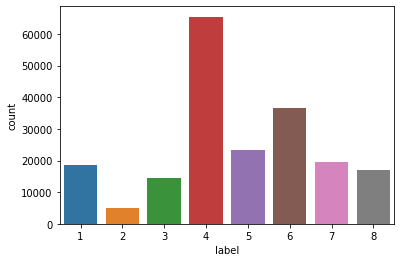

In [15]:
sns.countplot(x_data['label'])

The above plot showed that the dataset was imbalanced. Hence, downsampling was implemented

In [16]:
label_1 = x_data[x_data['label'] == 1]
label_1 = label_1.sample(10000, random_state=42)

label_2 = x_data[x_data['label'] == 2]
label_2 = label_2.sample(frac = 1, random_state=42)

label_3 = x_data[x_data['label'] == 3]
label_3 = label_3.sample(10000, random_state=42)

label_4 = x_data[x_data['label'] == 4]
label_4 = label_4.sample(10000, random_state=42)

label_5 = x_data[x_data['label'] == 5]
label_5 = label_5.sample(10000, random_state=42)

label_6 = x_data[x_data['label'] == 6]
label_6 = label_6.sample(10000, random_state=42)

label_7 = x_data[x_data['label'] == 7]
label_7 = label_7.sample(10000, random_state=42)

label_8 = x_data[x_data['label'] == 8]
label_8 = label_8.sample(10000, random_state=42)

x_data = pd.concat([label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8])

In [17]:
#prepare the data for tSNE
x_data = np.asarray(x_data)
x_data_Y = x_data[:,x_data.shape[1]-1]
x_data_Y = np.asarray(x_data_Y)
x_data_X = x_data[:,0:x_data.shape[1]-1]
x_data_X = np.asarray(x_data_X)

tSNE was used to visualise the AE result

perplexity =  800
num iter 1200
learning rate 100
num iter processed 1200


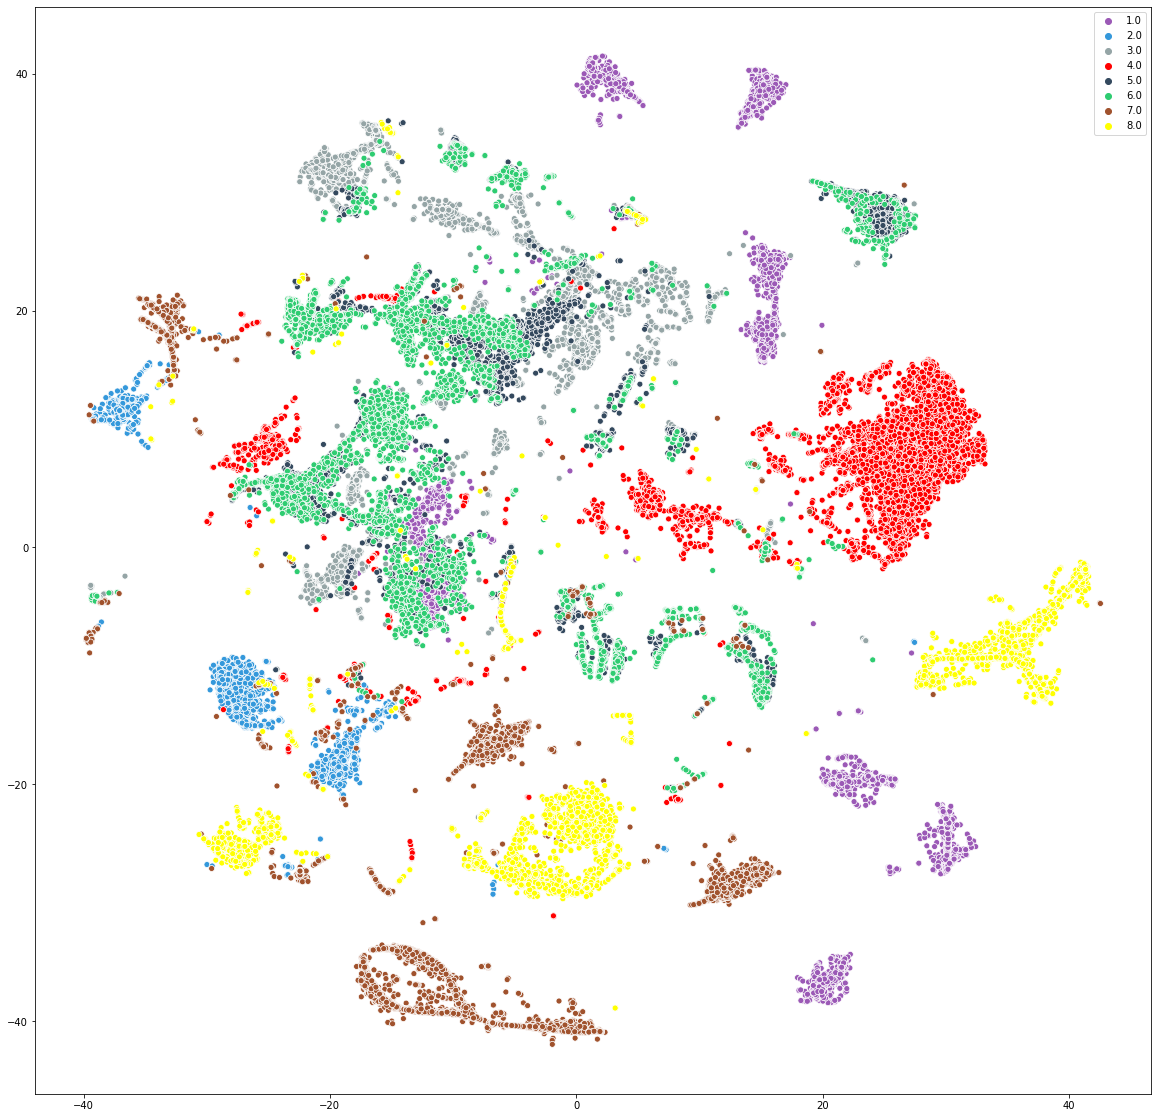

In [18]:
perplexity = [800]
n_iter = [1200]
learning_rate = [100]

for perplexity_value in (perplexity):
    for n_iter_value in (n_iter):
        for learning_rate_value in (learning_rate):
            
            print("perplexity = ", perplexity_value)
            print("num iter", n_iter_value)
            print("learning rate", learning_rate_value)
            
            tsne = TSNE(perplexity = perplexity_value, n_iter = n_iter_value, learning_rate = learning_rate_value, n_iter_without_progress = 50)
            X_embedded = tsne.fit_transform(x_data_X)
            print("num iter processed", tsne.n_iter)
            
            plt.figure(figsize=(20,20))
            CL = ["#9b59b6", "#3498db", "#95a5a6", "red", "#34495e", "#2ecc71", 'sienna', 'yellow']
            sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=x_data_Y, legend='full',palette = sns.color_palette(CL, 8))
            plt.show()